In [1]:
import numpy as np
import pandas as pd
import glob
import geopandas as gp

from ipywidgets import widgets, interact, fixed

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

import contextily as cx
import imageio
import xarray as xr
import math
import matplotlib.colors as colors
import rioxarray as rio
from shapely.geometry import mapping

In [2]:
output_dir = "../data/gsa_et/"
# Load GSAs shapefile and clean them so we only have "large GSAs"
gsa_shape = gp.read_file(
    "../shape/i03_Groundwater_Sustainability_Agencies_MapService.shp"
)
cv_shape = gp.read_file("../shape/Alluvial_Bnd.shp")
cv_shape.to_crs(3310, inplace=True)
gsa_shape.to_crs(3310, inplace=True)
cv_shape["geometry"] = cv_shape.geometry.buffer(10000)
gsa_cv = gsa_shape.within(cv_shape.loc[0, "geometry"])
gsa_cv = gsa_shape.loc[gsa_cv]
gsa_cv_cleaned_no_small = gsa_cv[gsa_cv["ShapeSTAre"] > 4e8].copy()
#gsa_cv_cleaned_no_small['variance'] = 0.0

In [3]:
et_data_file_names = glob.glob('../data/gsa_et_compiled/*')

In [4]:
et_data_file_gsas = []
for et_data_file_name in et_data_file_names:
    et_data_file_gsas.append(int(et_data_file_name.split("/")[3].split("_")[2][:-4]))

In [5]:
stamen_terrain = cimgt.Stamen('terrain-background')
stamen_terrain_2 = cimgt.Stamen('terrain-background')

In [6]:
type(stamen_terrain)

cartopy.io.img_tiles.Stamen

In [7]:
gsa_cv_cleaned_no_small.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 65 entries, 7 to 349
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    65 non-null     int64   
 1   GSA_ID      65 non-null     int64   
 2   GSA_Name    65 non-null     object  
 3   Loc_GSA_ID  0 non-null      object  
 4   Basin_Name  65 non-null     object  
 5   Posted_DT   65 non-null     object  
 6   GSA_URL     43 non-null     object  
 7   POC_Name    63 non-null     object  
 8   POC_Phone   63 non-null     object  
 9   POC_Email   63 non-null     object  
 10  Date_90_Da  65 non-null     object  
 11  Exclusive   65 non-null     object  
 12  Overlap     65 non-null     object  
 13  GSP_ID      65 non-null     int64   
 14  COMMENTS    0 non-null      object  
 15  Basin_Numb  65 non-null     object  
 16  Basin_Subb  65 non-null     object  
 17  Basin_Su_1  65 non-null     object  
 18  UPDATED_DT  65 non-null     object  
 19  M

In [8]:
#gsa_cv_cleaned_no_small.to_crs(3857, inplace=True)
#gsa_cv_cleaned_no_small.bounds

In [9]:
cropland_data = xr.open_dataset("../data/cropland/cropland_combined_3.nc")

In [10]:
cropland_data_copy = xr.open_dataset("../data/cropland/cropland_combined_3.nc")
cv_shape_copy = gp.read_file("../shape/Alluvial_Bnd.shp")
cv_shape_copy.to_crs(4326, inplace=True)

cropland_data_copy.rio.write_crs(4326, inplace=True)
cropland_data_copy.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
cropland_data_clipped = cropland_data_copy.rio.clip(
    cv_shape_copy.geometry.apply(mapping), cv_shape_copy.crs, drop=False)

In [11]:
unique_crops, unique_counts = np.unique(np.array(cropland_data_clipped["cropland"].isel(time=-1)), return_counts=True)
sorted_indices = np.argsort(unique_counts)
sorted_counts = unique_counts[sorted_indices][::-1]
print(sorted_counts)
sorted_crops = unique_crops[sorted_indices][::-1]
print(sorted_crops[10:20])

[232965 155466  83238 ...      1      1      1]
[ 24. 121. 195.  54.  72. 122. 111.   1. 225. 124.]


152 - shrub land

176 - grassland / pasture

142 - evergreen forest

75 - Almonds

61 - Fallowed

123 - Developed Land

143 - Mixed Forest

69 - Grapes

121 - Developed, Open Space

111 - Open Water

36 - Alfalfa

204 - Pistachios

3 - Rice

122 - Developed Low Intensity

76 - Walnuts

195 - Wetlands

54 - tomatoes

1 - corn

24 - Winter Wheat

72 - Citrus

225 - corn and winter wheat

124 - developed high intensity

In [12]:
def transform_cropland(cropland):
    '''Transform a cropland array into a new format.
    '''
    desired_classifications = [152, 176, 142, 75, 61, 123, 143, 69, 121, 111, 36, 204, 3, 122, 76, 195]
    new_cropland = cropland.copy()
    new_cropland[~np.isin(cropland, desired_classifications)] = 0 # water/void
    new_cropland[cropland==111] = 1 # Openwater
    new_cropland[np.isin(cropland, [152,176,142,143,195])] = 2 # shrubland
    new_cropland[np.isin(cropland, [121, 123, 122,124])] = 3 # Developed
    new_cropland[cropland==61] = 4 # Fallowed
    new_cropland[cropland==75] = 5 # Almonds
    new_cropland[cropland==204] = 6 # Pistachios
    new_cropland[cropland==76] = 7 # Walnuts
    new_cropland[cropland==69] = 8 # Grapes
    new_cropland[cropland==54] = 9 # Tomatoes
    new_cropland[cropland==72] = 10 # citrus
    new_cropland[cropland==3] = 11 #Rice
    new_cropland[cropland==36] = 12 # Alfalfa
    new_cropland[np.isin(cropland, [1,225,24])] = 13 # corn and winter wheat
    
    
    return new_cropland

In [13]:
test = transform_cropland(np.array(cropland_data["cropland"].isel(time=-1)))

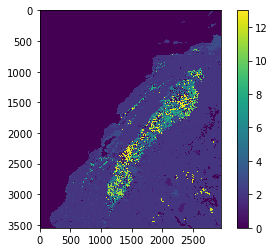

In [14]:
plt.imshow(test)
plt.colorbar()

In [15]:
for i in range(6):
    cropland_slice = cropland_data["cropland"].isel(time=16+i)
    # this is super jank
    cropland_data["cropland"].loc["20"+str(16+i)+"-01-01"] = transform_cropland(np.array(cropland_slice))

In [16]:
cmap = colors.ListedColormap(['blue', 'skyblue', 'green', 'grey', 'indigo', 'pink', 
                                  'cyan', 'black', 'limegreen','red', 'orange',  
                              'brown', 'yellow', 'purple'])
colormap_labels = ['ocean/other', 'inland water','shrubland', 'developed','fallowed', 
                   'almonds', 'pistachios', 'walnuts', 'grapes', 'tomatoes', 'citrus',
                  'rice', 'alfalfa', 'corn/winter wheat']
ticks = [0.5+i for i in range(len(colormap_labels))]
#bounds = [1, 2, 4, 7, 8]
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#fig.colorbar(
#    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
#    cax=ax,
#    extend='both',
#    ticks=bounds,
#    spacing='proportional',
#    orientation='horizontal',
#    label='Discrete intervals, some other units',
#)
print(ticks)

[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5]


In [17]:
gsa_cv_cleaned_no_small.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [24]:
def slider_plot_uncertainty(i_time):
    
    ### Comb through each GSA and get median + uncertainty
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        sample_file['et_ensemble_variance'] = sample_file['et_ensemble_mad_max'] - sample_file['et_ensemble_mad_min']
        sample_file_non_nan = sample_file[sample_file['et_ensemble_variance'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_variance'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_variance'][sample_file_non_nan_index[i_time]])
            sample_file_sample_value_2 = (sample_file_non_nan['et_ensemble_mad'][sample_file_non_nan_index[i_time]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            row_area = gsa_cv_cleaned_no_small.loc[row_id].geometry.area * 1e-6
            gsa_cv_cleaned_no_small.loc[row_id, 'variance'] = (sample_file_sample_value 
                                                              / row_area *1e6)
            
            gsa_cv_cleaned_no_small.loc[row_id, 'median'] = (sample_file_sample_value_2 / row_area * 1e6)
        except:
            continue
    sample_time = sample_file['time'][sample_file_non_nan_index[i_time]]
    
    ### plot results
    fig, ax = plt.subplots(1,2, figsize = (16,9), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ### ET Uncertainty
    staman_image = ax[0].add_image(stamen_terrain, 8)
    gsa_cv_cleaned_no_small.to_crs(4326).boundary.plot(ax=ax[0], color='red', linewidth=1)
    gsa_cv_cleaned_no_small.to_crs(4326).plot(column='variance', ax=ax[0], legend=True, vmin=0, vmax=50,
                                 legend_kwds={'label': "ET Uncertainty (mm)",
                                'orientation': "vertical"})    
    ax[0].set_title("Average ET Uncertainty: " + str(sample_time.year) + '-' + str(sample_time.month))
    xlim = ax[0].get_xlim()
    ylim = ax[0].get_ylim()
    ax[0].set_xticks([-122, -121, -120, -119])
    ax[0].set_yticks([35, 36, 37,38,39,40,41])
    ax[0].set_xlim(xlim)
    ax[0].set_ylim(ylim)
    ax[0].set_xlabel("Latitude")
    ax[0].set_ylabel("Longitude")
    ### Cropland
    gsa_cv_cleaned_no_small.to_crs(4326).boundary.plot(ax=ax[1], color='red', linewidth=1)
    cropland_time = math.floor(i_time/12)    
    tick_locs = np.linspace(cropland_slice.min(), cropland_slice.max(), 1)[1::2]
    cbar_tick_label = np.arange(cropland_slice.min(), cropland_slice.max() + 1)
    
    # this is super jank
    im = cropland_data["cropland"].isel(time=16+cropland_time).plot(ax=ax[1], cmap=cmap, add_colorbar=False,
                                                                   vmin=0, vmax=ticks[-1]+0.5)
    cbar = plt.colorbar(im, ax=ax[1], ticks=ticks)
    #cbar.set_ticks = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5]
    cbar.ax.set_yticklabels(colormap_labels)
    ax[1].set_xticks([-122, -121, -120, -119])
    ax[1].set_yticks([35, 36, 37,38,39,40,41])
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)
    ax[1].set_xlabel("Latitude")
    ax[1].set_ylabel("Longitude")
    ax[1].set_title("Cropland Data Layer: " + str(sample_time.year))
    
    
    
    plt.tight_layout()

In [26]:
interact(slider_plot_uncertainty, i_time = widgets.IntSlider(min=0, max=59, step=1))

interactive(children=(IntSlider(value=0, description='i_time', max=59), Output()), _dom_classes=('widget-inter…

<function __main__.slider_plot_uncertainty(i_time)>

In [22]:
def slider_plot_et_median(i_time):
    
    ### Comb through each GSA and get median + uncertainty
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        sample_file['et_ensemble_variance'] = sample_file['et_ensemble_mad_max'] - sample_file['et_ensemble_mad_min']
        sample_file_non_nan = sample_file[sample_file['et_ensemble_variance'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_variance'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_variance'][sample_file_non_nan_index[i_time]])
            sample_file_sample_value_2 = (sample_file_non_nan['et_ensemble_mad'][sample_file_non_nan_index[i_time]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            row_area = gsa_cv_cleaned_no_small.loc[row_id].geometry.area * 1e-6
            gsa_cv_cleaned_no_small.loc[row_id, 'variance'] = (sample_file_sample_value 
                                                              / row_area *1e6)
            
            gsa_cv_cleaned_no_small.loc[row_id, 'median'] = (sample_file_sample_value_2 / row_area * 1e6)
        except:
            continue
    sample_time = sample_file['time'][sample_file_non_nan_index[i_time]]
    
    ### plot results
    fig, ax = plt.subplots(1,2, figsize = (16,9), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ### ET Uncertainty
    staman_image = ax[0].add_image(stamen_terrain, 8)
    gsa_cv_cleaned_no_small.to_crs(4326).boundary.plot(ax=ax[0], color='red', linewidth=1)
    gsa_cv_cleaned_no_small.to_crs(4326).plot(column='median', ax=ax[0], legend=True, vmin=0, vmax=100,
                                 legend_kwds={'label': "Median ET Estimate (mm)",
                                'orientation': "vertical"})    
    ax[0].set_title("Median ET Estimate: " + str(sample_time.year) + '-' + str(sample_time.month))
    xlim = ax[0].get_xlim()
    ylim = ax[0].get_ylim()
    ax[0].set_xticks([-122, -121, -120, -119])
    ax[0].set_yticks([35, 36, 37,38,39,40,41])
    ax[0].set_xlim(xlim)
    ax[0].set_ylim(ylim)
    ax[0].set_xlabel("Latitude")
    ax[0].set_ylabel("Longitude")
    ### Cropland
    gsa_cv_cleaned_no_small.to_crs(4326).boundary.plot(ax=ax[1], color='red', linewidth=1)
    cropland_time = math.floor(i_time/12)    
    tick_locs = np.linspace(cropland_slice.min(), cropland_slice.max(), 1)[1::2]
    cbar_tick_label = np.arange(cropland_slice.min(), cropland_slice.max() + 1)
    
    # this is super jank
    im = cropland_data["cropland"].isel(time=16+cropland_time).plot(ax=ax[1], cmap=cmap, add_colorbar=False,
                                                                   vmin=0, vmax=ticks[-1]+0.5)
    cbar = plt.colorbar(im, ax=ax[1], ticks=ticks)
    #cbar.set_ticks = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5]
    cbar.ax.set_yticklabels(colormap_labels)
    ax[1].set_xticks([-122, -121, -120, -119])
    ax[1].set_yticks([35, 36, 37,38,39,40,41])
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)
    ax[1].set_xlabel("Latitude")
    ax[1].set_ylabel("Longitude")
    ax[1].set_title("Cropland Data Layer: " + str(sample_time.year))
    
    
    
    plt.tight_layout()

In [23]:
interact(slider_plot_et_median, i_time = widgets.IntSlider(min=0, max=59, step=1))

interactive(children=(IntSlider(value=0, description='i_time', max=59), Output()), _dom_classes=('widget-inter…

<function __main__.slider_plot_et_median(i_time)>

In [ ]:
for i_time in range(59):
    print(i_time)
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])

        sample_file_non_nan = sample_file[sample_file['et_ensemble_mad'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_mad'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_mad'][sample_file_non_nan_index[i_time]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            row_area = gsa_cv_cleaned_no_small.loc[row_id].geometry.area * 1e-6
            gsa_cv_cleaned_no_small.loc[row_id, 'median'] = (sample_file_sample_value / row_area * 1e6)
        except:
            continue
    sample_time = sample_file['time'][sample_file_non_nan_index[i_time]]

    fig = plt.figure(figsize = (14,9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_image(stamen_terrain, 8)
    #fig, ax = plt.subplots(1,1,figsize=(12,12))
    #cx.add_basemap(ax, crs='EPSG:3310', zoom=6)
    #madrid = cx.Place("California")
    #ax = madrid.plot()


    gsa_cv_cleaned_no_small.to_crs(4326).boundary.plot(ax=ax)
    gsa_cv_cleaned_no_small.to_crs(4326).plot(column='median', ax=ax, legend=True, vmin=0, vmax=150,
                                 legend_kwds={'label': "Median ET Estimate (mm)",
                                'orientation': "vertical"})

    ax.set_title("OpenET Median ET Estimate: " + str(sample_time.year) + '-' + str(sample_time.month))
    plt.savefig('../images/img_median_' + str(i_time) + '.png', 
                transparent = False,  
                facecolor = 'white'
               )
    plt.close()

In [ ]:
frames = []
for i_time in range(59):
    image = imageio.imread('../images/img_median_' + str(i_time) + '.png')
    frames.append(image)
imageio.mimsave('../images/example_median.gif', # output gif
                frames,          # array of input frames
                fps = 3)         # optional: frames per second

In [ ]:
for i_time in range(59):
    print(i_time)
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        sample_file['et_ensemble_variance'] = sample_file['et_ensemble_mad_max'] - sample_file['et_ensemble_mad_min']
        sample_file_non_nan = sample_file[sample_file['et_ensemble_variance'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_variance'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_variance'][sample_file_non_nan_index[i_time]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            row_area = gsa_cv_cleaned_no_small.loc[row_id].geometry.area * 1e-6
            gsa_cv_cleaned_no_small.loc[row_id, 'variance'] = (sample_file_sample_value / row_area * 1e6)
        except:
            continue
    sample_time = sample_file['time'][sample_file_non_nan_index[i_time]]

    fig = plt.figure(figsize = (14,9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_image(stamen_terrain, 8)
    #fig, ax = plt.subplots(1,1,figsize=(12,12))
    #cx.add_basemap(ax, crs='EPSG:3310', zoom=6)
    #madrid = cx.Place("California")
    #ax = madrid.plot()


    gsa_cv_cleaned_no_small.to_crs(4326).boundary.plot(ax=ax)
    gsa_cv_cleaned_no_small.to_crs(4326).plot(column='variance', ax=ax, legend=True, vmin=0, vmax=75,
                                 legend_kwds={'label': "ET Uncertainty (mm)",
                                'orientation': "vertical"})

    ax.set_title("Average ET Uncertainty: " + str(sample_time.year) + '-' + str(sample_time.month))
    plt.savefig('../images/img_uncertainty_' + str(i_time) + '.png', 
                transparent = False,  
                facecolor = 'white'
               )
    plt.close()

In [ ]:
frames = []
for i_time in range(59):
    image = imageio.imread('../images/img_uncertainty_' + str(i_time) + '.png')
    frames.append(image)
imageio.mimsave('../images/example_uncertainty.gif', # output gif
                frames,          # array of input frames
                fps = 3)         # optional: frames per second

# OLD

In [ ]:
fig = plt.figure(figsize = (14,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 8)
@widgets.interact(i_time=(0, 59, 1))
def update(i_time=0):
    """Remove old lines from plot and plot new one"""
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        sample_file['et_ensemble_variance'] = sample_file['et_ensemble_mad_max'] - sample_file['et_ensemble_mad_min']
        sample_file_non_nan = sample_file[sample_file['et_ensemble_variance'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_variance'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_variance'][sample_file_non_nan_index[i_time]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            gsa_cv_cleaned_no_small.loc[row_id, 'variance'] = (sample_file_sample_value 
                                                              / gsa_cv_cleaned_no_small.loc[row_id, 'ShapeSTAre'])
        except:
            continue
    sample_time = sample_file['time'][sample_file_non_nan_index[i_time]]
    gsa_cv_cleaned_no_small.plot(column='variance', ax=ax, legend=True, vmin=0, vmax=3e-11,
                                 legend_kwds={'label': "ET Uncertainty (mm/km^2)",
                                'orientation': "vertical"})
    plt.show()

In [ ]:
for j in range(60):
    print(j)
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        sample_file['et_ensemble_variance'] = sample_file['et_ensemble_mad_max'] - sample_file['et_ensemble_mad_min']
        sample_file_non_nan = sample_file[sample_file['et_ensemble_variance'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_variance'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_variance'][sample_file_non_nan_index[j]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            gsa_cv_cleaned_no_small.loc[row_id, 'variance'] = (sample_file_sample_value 
                                                              / gsa_cv_cleaned_no_small.loc[row_id, 'ShapeSTAre'])
        except:
            continue
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    gsa_cv_cleaned_no_small.boundary.plot(ax=ax)
    cx.add_basemap(ax)
    asset = gsa_cv_cleaned_no_small.plot(column='variance', ax=ax, legend=True)

In [ ]:
print(gsa_cv_cleaned_no_small['variance'].max())

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
gsa_cv_cleaned_no_small.boundary.plot(ax=ax)
asset = gsa_cv_cleaned_no_small.plot(column='variance', ax=ax, legend=True)

In [ ]:
for i in range(len(et_data_file_names)):
    sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])

    sample_file_non_nan = sample_file[sample_file['et_ensemble_mad'].notnull()]
    sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_mad'].notnull()]
    try:
        sample_file_sample_value = (sample_file_non_nan['et_ensemble_mad'][sample_file_non_nan_index[4]])
        row_id = gsa_cv_cleaned_no_small.index[
            gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
        row_area = gsa_cv_cleaned_no_small.loc[row_id].geometry.area * 1e-6
        gsa_cv_cleaned_no_small.loc[row_id, 'median'] = (sample_file_sample_value)
    except:
        continue

In [ ]:
gsa_cv_cleaned_no_small[gsa_cv_cleaned_no_small['GSA_Name']=='Wyandotte Creek GSA']

In [ ]:
@widgets.interact(i_time=(0, 59, 1))
def update(i_time=0):
    """Remove old lines from plot and plot new one"""
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        sample_file['et_ensemble_variance'] = sample_file['et_ensemble_mad_max'] - sample_file['et_ensemble_mad_min']
        sample_file_non_nan = sample_file[sample_file['et_ensemble_variance'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_variance'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_variance'][sample_file_non_nan_index[i_time]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            gsa_cv_cleaned_no_small.loc[row_id, 'variance'] = (sample_file_sample_value 
                                                              / gsa_cv_cleaned_no_small.loc[row_id, 'ShapeSTAre'])
        except:
            continue
    sample_time = sample_file['time'][sample_file_non_nan_index[i_time]]
    gsa_cv_cleaned_no_small.plot(column='variance', ax=ax, legend=True, vmin=0, vmax=3e-11,
                                 legend_kwds={'label': "ET Uncertainty (mm/km^2)",
                                'orientation': "vertical"})
    plt.show()

In [ ]:
fig = plt.figure(figsize = (14,9))
ax = plt.axes(projection=ccrs.PlateCarree())

# Get some 
cv_shape.to_crs(4326, inplace=True)
crs= cv_shape.to_crs(4326)

imextent = cv_shape.bounds


lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

print(lllon, lllat)
print(urlon, urlat)
ax.set_extent([lllon-.25, urlon+.25, lllat-.25, urlat+.25])

# Create a Stamen Terrain instance.

stamen_terrain
# Create a GeoAxes in the tile's projection.
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels= False
#gl.right_labels = False

#gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,1441))
#gl.ylocator = mticker.FixedLocator(np.linspace(0,90,721))
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'size': 9, 'color': 'gray'}
#gl.ylabel_style = {'size': 9, 'color': 'gray'}

#gsa_cv_cleaned_no_small.to_crs(4326).boundary.plot(ax=ax)
gsa_boundaries = ShapelyFeature(gsa_cv_cleaned_no_small.to_crs(4326).geometry.values,
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)
ax.add_image(stamen_terrain, 8)
ax.add_feature(gsa_boundaries)
ax.set_aspect('auto')

@widgets.interact(i_time=(0, 59, 1))
def update(i_time=0):
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        sample_file['et_ensemble_variance'] = sample_file['et_ensemble_mad_max'] - sample_file['et_ensemble_mad_min']
        sample_file_non_nan = sample_file[sample_file['et_ensemble_variance'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_variance'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_variance'][sample_file_non_nan_index[i_time]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            gsa_cv_cleaned_no_small.loc[row_id, 'variance'] = (sample_file_sample_value 
                                                              / gsa_cv_cleaned_no_small.loc[row_id, 'ShapeSTAre'])
        except:
            continue
    sample_time = sample_file['time'][sample_file_non_nan_index[i_time]]
    gsa_cv_cleaned_no_small.plot(column='variance', ax=ax, legend=True, vmin=0, vmax=3e-11,
                                 legend_kwds={'label': "ET Uncertainty (mm/km^2)",
                                'orientation': "vertical"})
    plt.show()

